In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time
import os
from PIL import Image
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch.utils.data as data
from torchvision.models import resnet18
from sklearn.model_selection import train_test_split
import sklearn.svm

In [2]:
# Data preprocessing and loading

# Define a transform to pre-process the image data
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Standard Normalization for ImageNet
])

# Load the dataset from the directory
data_dir = 'Dataset_Q1'  # replace with the path to your dataset.
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split the dataset into train and test sets 
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create loaders for the training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
def visualize_data_statistics(train_loader, test_loader):
    # Calculate mean and standard deviation of the datasets
    def calculate_stats(loader):
        mean = 0.
        std = 0.
        total_images_count = 0
        for images, _ in loader:
            # Flatten the channels
            batch_samples = images.size(0)  # batch size (the last batch can have smaller size!)
            images = images.view(batch_samples, images.size(1), -1)
            mean += images.mean(2).sum(0)
            std += images.std(2).sum(0)
            total_images_count += batch_samples

        mean /= total_images_count
        std /= total_images_count
        return mean, std, total_images_count

    train_mean, train_std, train_total = calculate_stats(train_loader)
    test_mean, test_std, test_total = calculate_stats(test_loader)

    # Print the statistics
    print(f"Training dataset mean: {train_mean}\nTraining dataset std: {train_std}\nTraining dataset total: {train_total} samples")
    print(f"Test dataset mean: {test_mean}\nTest dataset std: {test_std}\nTest dataset total: {test_total} samples")

In [4]:
def show_sample_images(loader, num_images=5):
    # Get a batch of training data
    images, labels = next(iter(loader))

    # Make a grid from batch
    for i in range(num_images):
        image = images[i].numpy()

        # In case of single-channel (grayscale), make it a 3D array for consistency
        if image.shape[0] == 1:
            image = np.squeeze(image)

        plt.subplot(1, num_images, i + 1)
        plt.tight_layout()
        plt.imshow(np.transpose(image, (1, 2, 0)))
        plt.title(f"Label: {labels[i]}")
        plt.xticks([])
        plt.yticks([])

    plt.show()


In [5]:
visualize_data_statistics(train_loader, test_loader)

Training dataset mean: tensor([-1.1992, -1.0965, -0.8694])
Training dataset std: tensor([0.8188, 0.8371, 0.8334])
Training dataset total: 2167 samples
Test dataset mean: tensor([-1.1929, -1.0901, -0.8630])
Test dataset std: tensor([0.8232, 0.8415, 0.8378])
Test dataset total: 929 samples


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


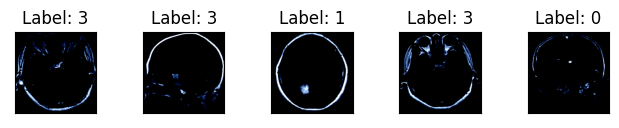

In [6]:
show_sample_images(train_loader, num_images=5)

In [7]:
# Training function.
def train(model, trainloader, optimizer, criterion, device):
    model.to(device)
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for _, data in enumerate(trainloader):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    # epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [8]:
# Testing function.
def test(model, testloader, criterion, device):
    model.eval()
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    
    predictions = []
    true_labels = []
    with torch.no_grad():
        for _, data in enumerate(testloader):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            valid_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc, predictions, true_labels

In [9]:
net = resnet18() # default resnet has no pretrained weights
net.fc = nn.Linear(net.fc.in_features, 4) # 4 classes

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [10]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
print(device)

cuda


In [12]:
n_epochs = 20

Accuracies = []
Loss = []
for i in range(n_epochs):
    epoch_loss, epoch_acc = train(net, train_loader, optimizer, criterion, device)
    Accuracies.append(epoch_acc)
    Loss.append(epoch_loss)
    print("Epoch: {}, Loss: {}, Accuracy: {}".format(i+1, epoch_loss, epoch_acc))

Epoch: 1, Loss: 1.2652777503518498, Accuracy: 38.94785417628057
Epoch: 2, Loss: 1.1164892123026007, Accuracy: 52.88417166589755
Epoch: 3, Loss: 1.014528908273753, Accuracy: 56.575911398246426
Epoch: 4, Loss: 0.8667901324875215, Accuracy: 64.19012459621597
Epoch: 5, Loss: 0.7543169623788666, Accuracy: 69.58929395477618
Epoch: 6, Loss: 0.6375724870492431, Accuracy: 75.91139824642362
Epoch: 7, Loss: 0.5308522288413609, Accuracy: 79.6031379787725
Epoch: 8, Loss: 0.40962259931599393, Accuracy: 86.70973696354407
Epoch: 9, Loss: 0.33088767550447407, Accuracy: 89.84771573604061
Epoch: 10, Loss: 0.21983588969006257, Accuracy: 94.41624365482234
Epoch: 11, Loss: 0.1604289822280407, Accuracy: 96.44670050761421
Epoch: 12, Loss: 0.12380266162183355, Accuracy: 97.46192893401016
Epoch: 13, Loss: 0.06639974178088938, Accuracy: 99.12321181356715
Epoch: 14, Loss: 0.04393656568273025, Accuracy: 99.7692662667282
Epoch: 15, Loss: 0.03635698965038447, Accuracy: 99.58467928011075
Epoch: 16, Loss: 0.0647565427

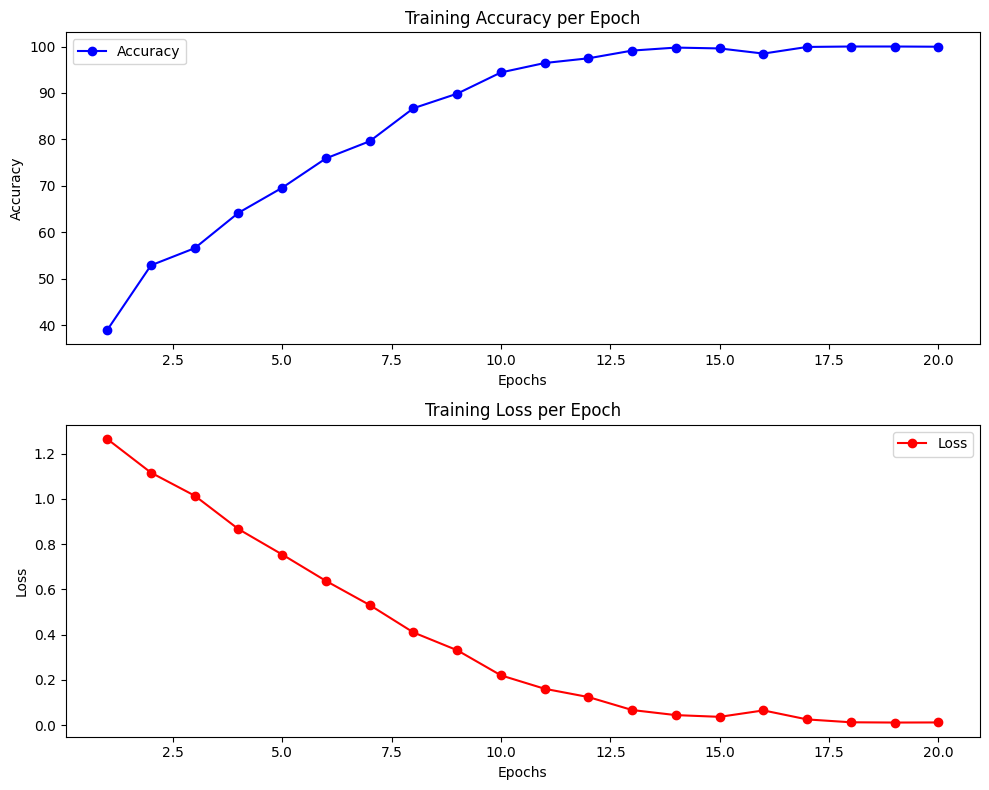

In [13]:
epochs = range(1, len(Accuracies) + 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plotting accuracy
ax1.plot(epochs, Accuracies, 'bo-', label='Accuracy')
ax1.set_title('Training Accuracy per Epoch')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plotting loss
ax2.plot(epochs, Loss, 'ro-', label='Loss')
ax2.set_title('Training Loss per Epoch')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [14]:
test_loss, test_acc, predictions, true_labels = test(net, test_loader, criterion, device)
print("Testing Loss: ", test_loss, "Testing Accuracy", test_acc)

Testing Loss:  0.32904089546451964 Testing Accuracy 88.69752421959096


In [15]:
class_names = list(dataset.class_to_idx.keys())

In [16]:
print(classification_report(true_labels, predictions, target_names=class_names))

                  precision    recall  f1-score   support

    glioma_tumor       0.86      0.87      0.86       276
meningioma_tumor       0.86      0.82      0.84       290
          normal       0.86      0.93      0.89       122
 pituitary_tumor       0.96      0.97      0.97       241

        accuracy                           0.89       929
       macro avg       0.89      0.90      0.89       929
    weighted avg       0.89      0.89      0.89       929



In [17]:
net_pre = resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
net_pre.fc = torch.nn.Linear(net.fc.in_features, 4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net_pre.parameters(), lr=0.001, momentum=0.9)

In [18]:
n_epochs = 20

Accuracies = []
Loss = []
for i in range(n_epochs):
    epoch_loss, epoch_acc = train(net_pre, train_loader, optimizer, criterion, device)
    Accuracies.append(epoch_acc)
    Loss.append(epoch_loss)
    print("Epoch: {}, Loss: {}, Accuracy: {}".format(i+1, epoch_loss, epoch_acc))

Epoch: 1, Loss: 0.7874367798075956, Accuracy: 67.97415782187356
Epoch: 2, Loss: 0.3494454122641507, Accuracy: 87.2634979233964
Epoch: 3, Loss: 0.19637305278550177, Accuracy: 94.37009690816798
Epoch: 4, Loss: 0.10678571051753619, Accuracy: 97.92339640055377
Epoch: 5, Loss: 0.07182901201988845, Accuracy: 98.66174434702354
Epoch: 6, Loss: 0.039987659944659644, Accuracy: 99.44623904014766
Epoch: 7, Loss: 0.028526189764413762, Accuracy: 99.72311952007384
Epoch: 8, Loss: 0.02069003352046232, Accuracy: 99.86155976003693
Epoch: 9, Loss: 0.017363726859912276, Accuracy: 99.95385325334564
Epoch: 10, Loss: 0.0137861789245268, Accuracy: 99.95385325334564
Epoch: 11, Loss: 0.01632052494267769, Accuracy: 99.81541301338255
Epoch: 12, Loss: 0.009839765974046552, Accuracy: 99.95385325334564
Epoch: 13, Loss: 0.010437260073719217, Accuracy: 99.90770650669127
Epoch: 14, Loss: 0.00566973619210972, Accuracy: 100.0
Epoch: 15, Loss: 0.006448786075720016, Accuracy: 99.95385325334564
Epoch: 16, Loss: 0.0075283909

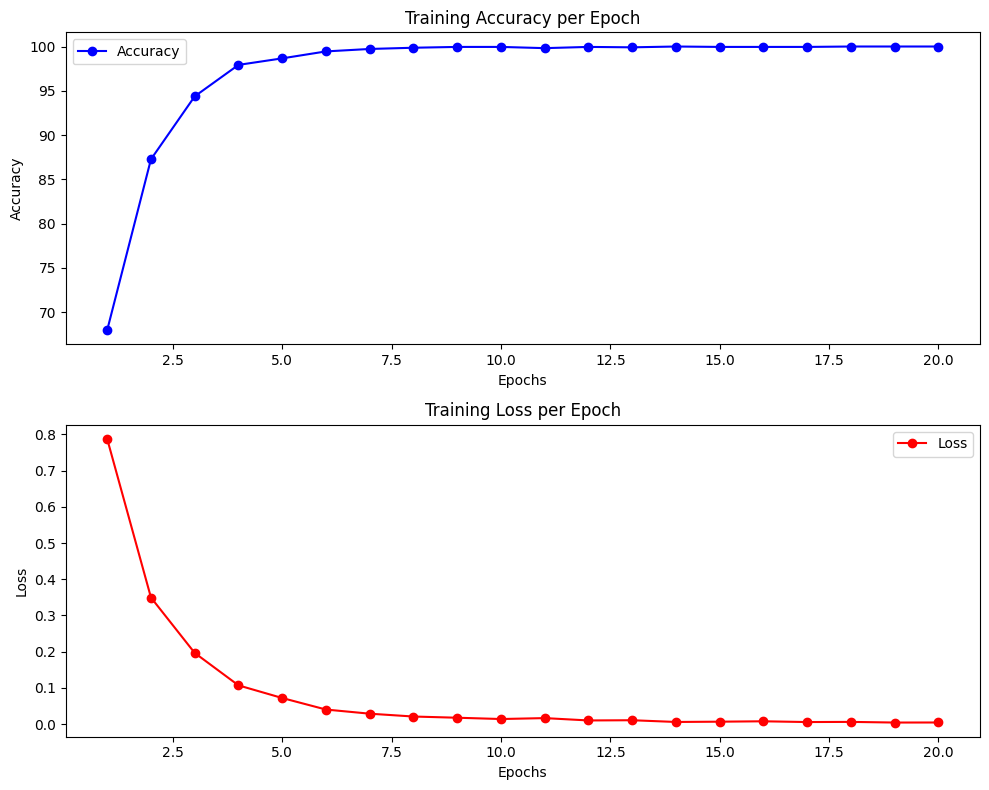

In [19]:
epochs = range(1, len(Accuracies) + 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plotting accuracy
ax1.plot(epochs, Accuracies, 'bo-', label='Accuracy')
ax1.set_title('Training Accuracy per Epoch')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plotting loss
ax2.plot(epochs, Loss, 'ro-', label='Loss')
ax2.set_title('Training Loss per Epoch')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [20]:
test_loss, test_acc, predictions, true_labels = test(net_pre, test_loader, criterion, device)
print("Testing Loss: ", test_loss, "Testing Accuracy", test_acc)

Testing Loss:  0.1885614468638475 Testing Accuracy 94.29494079655544


In [21]:
print(classification_report(true_labels, predictions, target_names=class_names))

                  precision    recall  f1-score   support

    glioma_tumor       0.94      0.92      0.93       276
meningioma_tumor       0.94      0.90      0.92       290
          normal       0.93      0.98      0.96       122
 pituitary_tumor       0.96      0.99      0.98       241

        accuracy                           0.94       929
       macro avg       0.94      0.95      0.95       929
    weighted avg       0.94      0.94      0.94       929



## Question 2

In [22]:
def process_dates(dates_raw):
    idxs, dates = [], []
    for i in range(len(dates_raw)):
        if dates_raw[i, 0].endswith('01-01') or dates_raw[i, 0].endswith('06-01') or not i:
            idxs.append(i)
            dates.append(dates_raw[i, 0])
    return idxs, dates

Text(0, 0.5, 'Close')

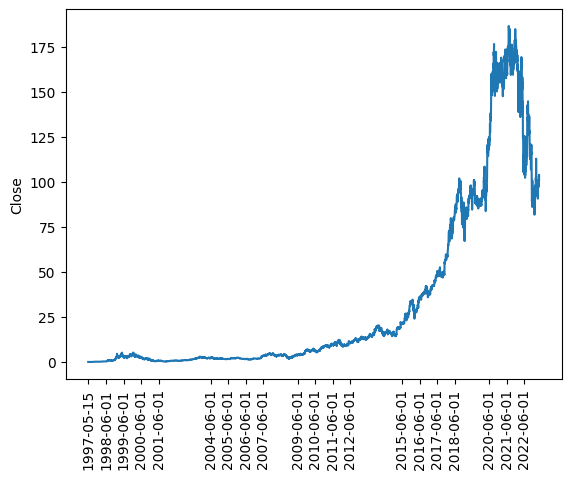

In [23]:
df = pd.read_csv('AMZN_Q2.csv')
time_series = df[["Close"]].values

x_labels = df[["Date"]].values
plt.figure()
plt.plot(time_series)
idxs, dates = process_dates(x_labels)
plt.xticks(idxs, dates, rotation='vertical')
plt.ylabel('Close')

In [24]:
scaler = MinMaxScaler()
timeseries = scaler.fit_transform(time_series)

In [25]:
def create_dataset(dataset, window):

    X, y = [], []
    for i in range(len(dataset)-window):
        feature = dataset[i:i+window]
        target = dataset[i+window]
        X.append(feature)
        y.append(target)
    return torch.tensor(np.array(X, dtype=np.float32)), torch.tensor(np.array(y, dtype=np.float32))

In [26]:
X, y = create_dataset(timeseries, window=10)
print(X.shape, y.shape)

torch.Size([6506, 10, 1]) torch.Size([6506, 1])


In [27]:
class LSTM_Model(nn.Module):
    def __init__(self):
        super().__init__()
        hidden_size = 50
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [28]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
print(device)

cuda


In [29]:
model = LSTM_Model()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X, y), batch_size=8)

n_epochs = 200
losses = []
for epoch in range(n_epochs):
    model.train()
    model.to(device)
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(X_batch)
        y_pred = y_pred[:, -1, :] # Many to one
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 10 != 0:
        continue
    model.eval()
    with torch.no_grad():
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X)
        y_pred = y_pred[:, -1, :] # Many to one
        train_rmse = np.sqrt(loss_fn(y_pred, y).cpu())
        losses.append(train_rmse)
        
    print("Epoch %d: train RMSE %.4f" % (epoch, train_rmse))

Epoch 0: train RMSE 0.2740
Epoch 10: train RMSE 0.2484
Epoch 20: train RMSE 0.0285
Epoch 30: train RMSE 0.0150
Epoch 40: train RMSE 0.0155
Epoch 50: train RMSE 0.0154
Epoch 60: train RMSE 0.0132
Epoch 70: train RMSE 0.0113
Epoch 80: train RMSE 0.0108
Epoch 90: train RMSE 0.0123
Epoch 100: train RMSE 0.0132
Epoch 110: train RMSE 0.0130
Epoch 120: train RMSE 0.0127
Epoch 130: train RMSE 0.0151
Epoch 140: train RMSE 0.0164
Epoch 150: train RMSE 0.0168
Epoch 160: train RMSE 0.0170
Epoch 170: train RMSE 0.0171
Epoch 180: train RMSE 0.0172
Epoch 190: train RMSE 0.0173


Text(0.5, 1.0, 'Training Loss')

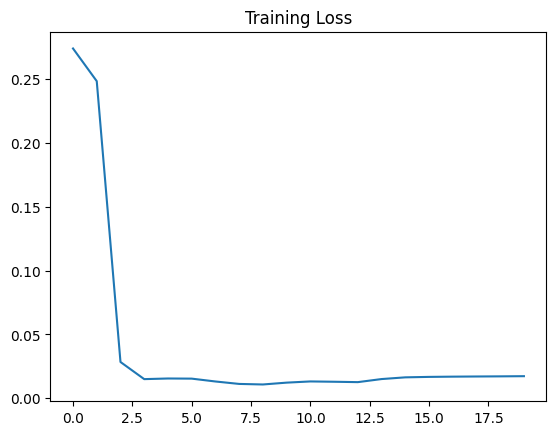

In [30]:
plt.figure()

plt.plot(losses)
plt.title("Training Loss")

In [31]:
model.eval()
with torch.no_grad():
    X = X.to(device)
    y = y.to(device)
    y_pred = model(X)
    y_pred = y_pred[:, -1, :].cpu().numpy()
    y = y.cpu().numpy()

Text(0, 0.5, 'Close')

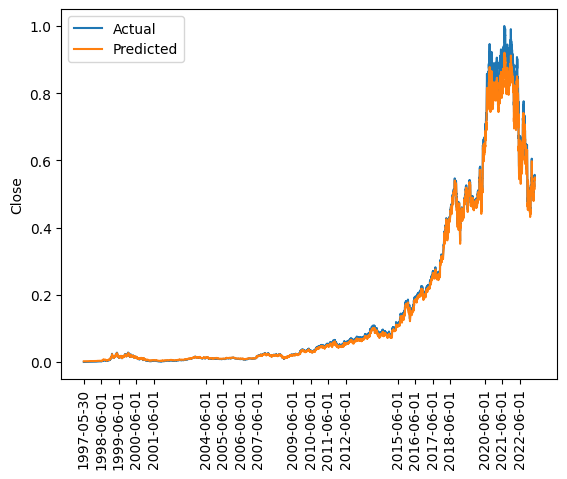

In [32]:
plt.figure()

plt.plot(y, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
idxs, dates = process_dates(x_labels[10:])
plt.xticks(idxs, dates, rotation='vertical')
plt.ylabel('Close')

## Question 3

In [33]:
df = pd.read_csv("survey lung cancer_Q3.csv")
df['GENDER'].replace(['M', 'F'], [1, 0], inplace=True)
df['LUNG_CANCER'].replace(['YES', 'NO'], [1, 0], inplace=True)
y = df.pop('LUNG_CANCER').to_numpy()
X = df.to_numpy()

In [34]:
X

array([[ 1, 69,  1, ...,  2,  2,  2],
       [ 1, 74,  2, ...,  2,  2,  2],
       [ 0, 59,  1, ...,  2,  1,  2],
       ...,
       [ 1, 58,  2, ...,  1,  1,  2],
       [ 1, 67,  2, ...,  2,  1,  2],
       [ 1, 62,  1, ...,  1,  2,  1]])

In [35]:
print(df.head())

   GENDER  AGE  SMOKING  YELLOW_FINGERS  ANXIETY  PEER_PRESSURE  \
0       1   69        1               2        2              1   
1       1   74        2               1        1              1   
2       0   59        1               1        1              2   
3       1   63        2               2        2              1   
4       0   63        1               2        1              1   

   CHRONIC DISEASE  FATIGUE   ALLERGY   WHEEZING  ALCOHOL CONSUMING  COUGHING  \
0                1         2         1         2                  2         2   
1                2         2         2         1                  1         1   
2                1         2         1         2                  1         2   
3                1         1         1         1                  2         1   
4                1         1         1         2                  1         2   

   SHORTNESS OF BREATH  SWALLOWING DIFFICULTY  CHEST PAIN  
0                    2                      2     

In [36]:
print(df.describe())

           GENDER         AGE     SMOKING  YELLOW_FINGERS     ANXIETY  \
count  309.000000  309.000000  309.000000      309.000000  309.000000   
mean     0.524272   62.673139    1.563107        1.569579    1.498382   
std      0.500221    8.210301    0.496806        0.495938    0.500808   
min      0.000000   21.000000    1.000000        1.000000    1.000000   
25%      0.000000   57.000000    1.000000        1.000000    1.000000   
50%      1.000000   62.000000    2.000000        2.000000    1.000000   
75%      1.000000   69.000000    2.000000        2.000000    2.000000   
max      1.000000   87.000000    2.000000        2.000000    2.000000   

       PEER_PRESSURE  CHRONIC DISEASE    FATIGUE     ALLERGY     WHEEZING  \
count     309.000000       309.000000  309.000000  309.000000  309.000000   
mean        1.501618         1.504854    1.673139    1.556634    1.556634   
std         0.500808         0.500787    0.469827    0.497588    0.497588   
min         1.000000         1.000

In [37]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [38]:
svm = sklearn.svm.SVC(C=1000, gamma=0.001)
svm.fit(X_train, y_train)

y_preds = svm.predict(X_train)
print("Train Classification Report: \n", classification_report(y_train, y_preds))

y_preds = svm.predict(X_test)
print("Test Classification Report: \n", classification_report(y_test, y_preds))

Train Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.75      0.78        24
           1       0.97      0.98      0.97       192

    accuracy                           0.95       216
   macro avg       0.89      0.86      0.88       216
weighted avg       0.95      0.95      0.95       216

Test Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.47      0.61        15
           1       0.91      0.99      0.94        78

    accuracy                           0.90        93
   macro avg       0.89      0.73      0.78        93
weighted avg       0.90      0.90      0.89        93

